In [31]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import tensorboard as tb
from tensorboard.backend.event_processing import event_accumulator
from random import choices
from itertools import combinations

In [32]:
def age_debiasing(predicted_ages, chronological_ages):
    
    predicted_ages = predicted_ages.to_numpy()
    chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

def age_debiasing(predicted_ages, chronological_ages):
    
    predicted_ages = predicted_ages.to_numpy()
    chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

def tensorboard_reader(directory, tag='AgeDelta/epoch'):
    """
    Sources: 
    https://stackoverflow.com/questions/41074688/how-do-you-read-tensorboard-files-programmatically
    https://stackoverflow.com/questions/37304461/tensorflow-importing-data-from-a-tensorboard-tfevent-file
    """
    
    for dataset in ['train', 'validation']:
    
        dct = {}
        steps = []
        values = []
    
        if dataset == 'train':
            dir_name = directory + '/train/'
        else:
            dir_name = directory + '/validation/'

        list_of_files = os.listdir(dir_name)

        for file in list_of_files:
            file_name=dir_name+file
#             print(file_name)
            ea = event_accumulator.EventAccumulator(file_name,
              size_guidance={
              event_accumulator.COMPRESSED_HISTOGRAMS: 500,
              event_accumulator.IMAGES: 4,
              event_accumulator.AUDIO: 4,
              event_accumulator.SCALARS: 0,
              event_accumulator.HISTOGRAMS: 1,
          })
            ea.Reload()
#             print(ea.Tags())
            if tag in ea.Tags()['scalars']:
                for e in ea.Scalars(tag):
                    step = e.step
                    value = e.value
                    steps.append(step)
                    values.append(value)

        dct['step'] = steps
        
        if dataset == 'train':
            dct['train'] = values
            dfp = pd.DataFrame.from_dict(dct)
        else:
            dct['validation'] = values
            dfv = pd.DataFrame.from_dict(dct)

    df = pd.merge(dfp, dfv, how='left', on='step')
    df = df.sort_values('step')
    
    return df

def linear_plotter(x, y_train, y_validation, xlabel, ylabel, title, ylim_flag=False, xlim=None):
    
    if isinstance(x, np.ndarray):
        pass
    else:
        x = x.values
        y_train = y_train.values
        y_validation = y_validation.values
    
    plt.figure(figsize=[14.4,7.2])
    plt.plot(x, y_train, label='Train')
    plt.plot(x, y_validation, label='Validation')
    plt.xlabel(xlabel)
    if ylim_flag == True:
        ylim_min = -0.25
        ylim_max = np.max(y_train) + 5
        plt.ylim((ylim_min, ylim_max))
    best_validation = np.min(y_validation)
    best_epoch = x[np.where(y_validation == np.min(y_validation))[0][0]]
    best_train = y_train[np.where(y_validation == np.min(y_validation))[0][0]]
    gap = best_train - best_validation
    print(best_epoch, best_validation)
    print(-gap)
    plt.scatter(x=best_epoch, y=best_validation, s=100, marker='*', color='red', label='Selected Best Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()
    
def linear_plotter_comparison(Xs, Ys, Labels,
                              xlabel, ylabel, title, ylim_flag=False):
    
    plt.figure(figsize=[7,5])
    for idx, x in enumerate(Xs):
        plt.plot(x, Ys[idx], label=Labels[idx])
    plt.xlabel(xlabel)
    if ylim_flag == True:
        ylim_min = -0.25
        y_max = [np.max(Ys[idx]) for idx in range(len(Ys))]
        ylim_max = min(y_max)
        plt.ylim((ylim_min, ylim_max))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_everything(network='49', ylim2=[2.175, 2.45], control=False):
    dfs = []
    names = []
    range_points = [1,2,3]
#     network = '49'
    preambul = 'MM'
    if control == True:
        preambul = 'AM'
        range_points = [10,11,12]

    tag = 'AgeDelta/epoch'
    for i in range_points:
        name = preambul + str(int(i)) + '-' + network
        directory = '../logs/' + name
        df = tensorboard_reader(directory=directory, tag=tag)
        dfs.append(df)
        names.append(name)

    dfs2 = []
    names2 = []
    range_points = [1,2,3]
#     network = '49'

    tag2 = 'LearningRate/iteration'
    for i in range_points:
        name2 = preambul + str(int(i)) + '-' + network
        directory2 = '../logs/' + name
    #     if os.path.isdir(directory):
        df2 = tensorboard_reader(directory=directory2, tag=tag2)
        dfs2.append(df2)
        names2.append(name2)

    for i, df in enumerate(dfs):
        name = names[i]
        df = df.dropna(axis=0)
        linear_plotter(x=df.step, y_train=df.train, y_validation=df.validation, 
                       xlabel='Epochs', ylabel=tag, title=name, xlim=[-2, 300])

    Xs = [dfs[i].step.values for i in range(len(dfs))]
    Ys = [dfs[i].validation.values for i in range(len(dfs))]
    Labels = [preambul + str(int(i)) + '-' + network for i in range_points]
    xlabel='Epochs'
    ylabel='AgeDelta/epoch'

    plt.figure(figsize=[14.4,7.2])
    for idx, x in enumerate(Xs):
        y = Ys[idx]
        x = np.delete(x, np.argwhere(np.isnan(y)))
        y = np.delete(y, np.argwhere(np.isnan(y)))
        plt.plot(x, y, label=Labels[idx], alpha=0.3)
        best_validation = np.min(y)
        best_epoch = x[np.where(y == np.min(y))[0][0]]
        label = 'Selected Best Epoch for ' + Labels[idx]
        if idx < 3:
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='*', label=label)
        else:
            plt.scatter(x=best_epoch, y=best_validation, s=150, marker='o', label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.ylim(ylim2)
    plt.xlim([-1,300])
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')

#     for idx in range(len(dfs2)):
#         dfs2[idx].step = dfs2[idx].step / (dfs2[idx].step.max() / dfs[idx].step.max())

#     ncols=2
#     nrows=1
#     sz=7.2
#     title_font_size=22
#     ticks_font_size=18
#     legend_font = 18

#     for idx in range(len(dfs)):

#         fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(ncols*sz,nrows*sz))

#         axes = axes.ravel()

#         axes[0] = plt.subplot()
#         ax2 = axes[0].twinx()
#         l1, = axes[0].plot(dfs[idx].step, dfs[idx].validation, color='tab:orange')
#         l2, = ax2.plot(dfs2[idx].step, dfs2[idx].train, linestyle='dotted', color='b')

#         best_validation = np.min(dfs[idx].validation.values)
#         best_epoch = dfs[idx].step.values[np.where(dfs[idx].validation.values == best_validation)[0][0]]
#         l3 = axes[0].scatter(x=best_epoch, y=best_validation, s=100, marker='*', color='red')


#         plt.legend([l1, l2, l3], ['Val Curve', 'LR', 'Selected Best Epoch'])




#         axes[0].set_ylabel('Age Delta')
#         ax2.set_ylabel('Learning Rate')
#         axes[0].set_xlabel('Training Epochs')
#         ax2.grid(linestyle='--')

#         axes[0].set_xlim([-2, 300])

In [3]:
!ls '../../agemapper/'

Analsysis Female New
Analysis - SFCN vs HGL
Analysis Male New
Analysis Project 2
Analysis_data
MRI-based age prediction using hidden Markov models - ScienceDirect.html
additional_codes
data_examples
figures
logs
multi-age-mapper
predictions


In [4]:
df = pd.read_pickle('../../agemapper/Analsysis Female New/female_test.pkl')
df_test = {}
df_test['Unnamed: 0'] = df.iloc[0].dataframe['Unnamed: 0'].to_list()
for idx in range(len(df)):
    name = df.iloc[idx].modality
    data = df.iloc[idx].dataframe.mean_output_age.to_list()
    df_test[name] = data
    
df_test = pd.DataFrame.from_dict(df_test)
df_test['target_age'] = df.iloc[0].dataframe.target_age.to_list()

df_testA, df_testB = train_test_split(df_test, test_size=0.5, random_state=1)
subjectsA = df_testA['Unnamed: 0'].to_list()
subjectsB = df_testB['Unnamed: 0'].to_list()
del df_testA, df_testB, df

In [5]:
# CNN

net1 = "AC3-1" # T1NL
# net2 = 'AC2-6' # SWI
# net3 = 'AC3-3' # FA
# net4 = 'AC1-5' # rsfMRI0
# net5 = 'AC5-7' # tfMRI-1
# net6 = 'AC6-8' # dmri tracts
# net7 = "AC6-16" # T2 Lessions


# net19 = '11' # tfMRI 5

dfs = [
    net1,
#     net2,
#     net3,
#     net4,
#     net5,
#     net6,
#     net7,
]

names = [

    'T1_nonlinear',           #1
#     'swi',                    #2
#     'tbss_FA',                #3
#     'rsfmri_0',               #4
#     'tfmri_1',                #5
#     'tracts',                 #6
#     'T2_lessions',            #7
    
]

stdSTD = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    
dfs1, dfs2, dfs3 = [], [], []
dfs4, dfs5, dfs6 = [], [], []
dfs7, dfs8, dfs9 = [], [], []
dfs10 , dfs11 = [], []
# dfs11, dfs12 = [], [], []

dfs1 = dfs.copy()
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
dfs5 = dfs.copy()
dfs6 = dfs.copy()
dfs7 = dfs.copy()
dfs8 = dfs.copy()
dfs9 = dfs.copy()
dfs10 = dfs.copy()
dfs11 = dfs.copy()
# dfs12 = dfs.copy()


for idx in range(len(dfs)):
    
    dfs1[idx] = '../predictions/' + dfs1[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_0'
    dfs2[idx] = '../predictions/' + dfs2[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_0.2'
    dfs3[idx] = '../predictions/' + dfs3[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_0.4'
    dfs4[idx] = '../predictions/' + dfs4[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_0.6'
    dfs5[idx] = '../predictions/' + dfs5[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_0.8'
    dfs6[idx] = '../predictions/' + dfs6[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_1'
    dfs7[idx] = '../predictions/' + dfs7[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_1.2'
    dfs8[idx] = '../predictions/' + dfs8[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_1.4'
    dfs9[idx] = '../predictions/' + dfs9[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_1.6'
    dfs10[idx] = '../predictions/' + dfs10[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_1.8'
    dfs11[idx] = '../predictions/' + dfs11[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_2'
#     dfs12[idx] = '../predictions/' + dfs12[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_0.2'

    
for idx in range(len(dfs)):
    dfs1[idx] = pd.read_csv(dfs1[idx])
    dfs2[idx] = pd.read_csv(dfs2[idx])
    dfs3[idx] = pd.read_csv(dfs3[idx])
    dfs4[idx] = pd.read_csv(dfs4[idx])
    dfs5[idx] = pd.read_csv(dfs5[idx])
    dfs6[idx] = pd.read_csv(dfs6[idx])
    dfs7[idx] = pd.read_csv(dfs7[idx])
    dfs8[idx] = pd.read_csv(dfs8[idx])
    dfs9[idx] = pd.read_csv(dfs9[idx])
    dfs10[idx] = pd.read_csv(dfs10[idx])
    dfs11[idx] = pd.read_csv(dfs11[idx])
#     dfs12[idx] = pd.read_csv(dfs12[idx])
    

subjects = subjectsB

for idx in range(len(dfs)):
    for subj in dfs1[idx]['Unnamed: 0'].to_list():
        if subj not in subjects:
            dfs1[idx] = dfs1[idx].drop(dfs1[idx][dfs1[idx]['Unnamed: 0'] == subj].index)
            dfs2[idx] = dfs2[idx].drop(dfs2[idx][dfs2[idx]['Unnamed: 0'] == subj].index)
            dfs3[idx] = dfs3[idx].drop(dfs3[idx][dfs3[idx]['Unnamed: 0'] == subj].index)
            dfs4[idx] = dfs4[idx].drop(dfs4[idx][dfs4[idx]['Unnamed: 0'] == subj].index)
            dfs5[idx] = dfs5[idx].drop(dfs5[idx][dfs5[idx]['Unnamed: 0'] == subj].index)
            dfs6[idx] = dfs6[idx].drop(dfs6[idx][dfs6[idx]['Unnamed: 0'] == subj].index)
            dfs7[idx] = dfs7[idx].drop(dfs7[idx][dfs7[idx]['Unnamed: 0'] == subj].index)
            dfs8[idx] = dfs8[idx].drop(dfs8[idx][dfs8[idx]['Unnamed: 0'] == subj].index)
            dfs9[idx] = dfs9[idx].drop(dfs9[idx][dfs9[idx]['Unnamed: 0'] == subj].index)
            dfs10[idx] = dfs10[idx].drop(dfs10[idx][dfs10[idx]['Unnamed: 0'] == subj].index)
            dfs11[idx] = dfs11[idx].drop(dfs11[idx][dfs11[idx]['Unnamed: 0'] == subj].index)
#             dfs12[idx] = dfs12[idx].drop(dfs12[idx][dfs12[idx]['Unnamed: 0'] == subj].index)
    
    
for idx in range(len(dfs)):
    dfs[idx] = pd.merge(dfs1[idx], dfs2[idx], on='Unnamed: 0', how='inner')
    dfs[idx] = pd.merge(dfs[idx], dfs3[idx], on='Unnamed: 0', how='inner')
    
    dfs[idx].rename({
        'target_age_x': 'target_age_original',
        'output_age_x': 'output_age_1',
        'age_delta_x': 'age_delta_1',
        'loss_x': 'loss_1',
        'target_age_y': 'target_age_2',
        'output_age_y': 'output_age_2',
        'age_delta_y': 'age_delta_2',
        'loss_y': 'loss_2',
        'target_age': 'target_age_3',
        'output_age': 'output_age_3',
        'age_delta': 'age_delta_3',
        'loss': 'loss_3',
    }, axis=1, inplace=True)
    
    dfs[idx].drop(['target_age_2', 'target_age_3'], axis=1, inplace=True)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs4[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_4',
        'age_delta': 'age_delta_4',
        'loss': 'loss_4',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs5[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_5',
        'age_delta': 'age_delta_5',
        'loss': 'loss_5',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs6[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_6',
        'age_delta': 'age_delta_6',
        'loss': 'loss_6',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
      
    
    dfs[idx] = pd.merge(dfs[idx], dfs7[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_7',
        'age_delta': 'age_delta_7',
        'loss': 'loss_7',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs8[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_8',
        'age_delta': 'age_delta_8',
        'loss': 'loss_8',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs9[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_9',
        'age_delta': 'age_delta_9',
        'loss': 'loss_9',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs10[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_10',
        'age_delta': 'age_delta_10',
        'loss': 'loss_10',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs11[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_11',
        'age_delta': 'age_delta_11',
        'loss': 'loss_11',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs12[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_12',
#         'age_delta': 'age_delta_12',
#         'loss': 'loss_12',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    
    
    
    
    dfs[idx].rename({
        'target_age_original': 'target_age',
    }, axis=1, inplace=True)
    
#     dfs[idx]['mean_output_age'] = dfs[idx][['output_age_1', 'output_age_2', 'output_age_3',
#                                            'output_age_4', 'output_age_5', 'output_age_6',
#                                            'output_age_7', 'output_age_8', 'output_age_9',
#                                            ]].mean(axis=1)
#     dfs[idx]['mean_age_delta'] = dfs[idx]['mean_output_age'] - dfs[idx]['target_age']
    
for idx in range(len(dfs)):
    for idx2 in range(1,12):
        key1 = 'output_age_decon_' + str(idx2)
        key2 = 'output_age_' + str(idx2)
        dfs[idx][key1] = age_debiasing(dfs[idx][key2], dfs[idx].target_age)
        key3 = 'age_delta_decon_' + str(idx2)
        dfs[idx][key3] = dfs[idx][key1] - dfs[idx].target_age
    
#     dfs[idx]['output_age_decon'] = age_debiasing(dfs[idx].mean_output_age, dfs[idx].target_age)
#     dfs[idx]['age_delta_decon'] = dfs[idx].output_age_decon - dfs[idx].target_age





header = "{:12} : {:4} | {:4} | {:4} | {:4} | {:4} | {:4} | {:4} | {:4} | {:4} | {:4} | {:4} |"
header2 = ['Mod/Std', '0', "0.2", "0.4", '0.6', "0.8", "1", '1.2', "1.4", "1.6",'1.8', "2", ""]
rows =  "{:12} : {:3.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} | {:.2f} "





print(header.format(*header2))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(dfs)):
    print(rows.format(
        names[idx],
        np.abs(dfs[idx].age_delta_1).mean(), 
        np.abs(dfs[idx].age_delta_2).mean(),
        np.abs(dfs[idx].age_delta_3).mean(),
        np.abs(dfs[idx].age_delta_4).mean(), 
        np.abs(dfs[idx].age_delta_5).mean(),
        np.abs(dfs[idx].age_delta_6).mean(),
        np.abs(dfs[idx].age_delta_7).mean(), 
        np.abs(dfs[idx].age_delta_8).mean(),
        np.abs(dfs[idx].age_delta_9).mean(),
        np.abs(dfs[idx].age_delta_10).mean(), 
        np.abs(dfs[idx].age_delta_11).mean(),
#         np.abs(dfs[idx].age_delta_12).mean(),
    )
         )
    
print('\n')      

# Modality        : Run1     |  Run2  |  Run3  |  Run4  |  Run5  |  Run6  |  Run7  |  Run8  |  Run9  |  MAE  |  
# -----------------------------------------------------------------------------------------------
# T1_nonlinear    :   2.490  |  2.483 |  2.382 |  2.476   |  2.467 |  2.504 |  2.487 |  2.439 |  2.399 |  2.190   
# T2_nonlinear    :   2.330  |  2.361 |  2.314 |  2.349   |  2.327 |  2.323 |  2.297 |  2.316 |  2.356 |  2.086   
# tbss_FA         :   2.891  |  2.906 |  2.802 |  2.803   |  2.909 |  2.819 |  2.839 |  2.887 |  2.865 |  2.587   
# tbss_MD         :   3.082  |  3.059 |  2.980 |  3.038   |  3.084 |  3.009 |  3.078 |  3.059 |  2.948 |  2.804   
# rsfmri_0        :   4.397  |  4.485 |  4.435 |  4.471   |  4.545 |  4.476 |  4.451 |  4.478 |  4.406 |  4.220   
# swi             :   3.343  |  3.142 |  3.273 |  3.333   |  3.277 |  3.329 |  3.226 |  3.168 |  3.169 |  2.939   
# tfmri_1         :   3.802  |  3.834 |  3.764 |  3.703   |  3.691 |  3.742 |  3.746 |  3.742 |  3.810 |  3.407   
# tracts          :   3.357  |  3.309 |  3.313 |  3.319   |  3.292 |  3.271 |  3.395 |  3.376 |  3.346 |  3.070   
# tbss_MO         :   3.160  |  3.140 |  3.060 |  3.169   |  3.098 |  3.132 |  3.164 |  3.174 |  3.066 |  2.873   
# tbss_ISOVF_s    :   3.490  |  3.478 |  3.587 |  3.421   |  3.431 |  3.494 |  3.505 |  3.479 |  3.693 |  3.286   
# tbss_L2         :   3.052  |  2.984 |  2.992 |  2.992   |  2.977 |  2.954 |  3.038 |  3.132 |  3.024 |  2.806   
# rsfmri_2        :   4.399  |  4.404 |  4.498 |  4.464   |  4.547 |  4.643 |  4.377 |  4.612 |  4.426 |  4.159   
# rsfmri_10       :   4.714  |  4.539 |  4.479 |  4.515   |  4.477 |  4.560 |  4.506 |  4.553 |  4.512 |  4.243   
# rsfmri_5        :   4.408  |  4.390 |  4.315 |  4.291   |  4.392 |  4.376 |  4.405 |  4.424 |  4.414 |  4.160   
# rsfmri_21       :   4.529  |  4.398 |  4.515 |  4.465   |  4.244 |  4.366 |  4.303 |  4.340 |  4.424 |  4.060   
# T2_lessions     :   4.080  |  4.266 |  4.113 |  4.069   |  4.038 |  4.014 |  4.023 |  4.145 |  4.074 |  3.936   
# tbss_FA_s       :   3.084  |  3.175 |  3.049 |  2.992   |  3.080 |  3.102 |  3.074 |  3.032 |  3.156 |  2.903   
# tbss_L3_s       :   3.380  |  3.345 |  3.281 |  3.404   |  3.266 |  3.294 |  3.258 |  3.312 |  3.317 |  3.132   


Mod/Std      : 0    | 0.2  | 0.4  | 0.6  | 0.8  | 1    | 1.2  | 1.4  | 1.6  | 1.8  | 2    |
-------------------------------------------------------------------------------------------------------
T1_nonlinear : 2.38 | 5.00 | 11.06 | 16.36 | 24.77 | 36.16 | 52.19 | 78.96 | 116.11 | 175.14 | 268.80 




In [6]:
d = {'modality':names, 'dataframe':dfs}
df = pd.DataFrame(data=d)
df.to_pickle('female_test_testB_CNN_RandomBiasField.pkl', protocol = 4)

In [20]:
# CNN

net1 = "SN5-1" # T1NL
# net2 = 'SN2-9' # SWI
# net3 = 'SN3-3' # FA
# net4 = 'SN3-8' # rsfMRI0
# net5 = 'SN6-10' # tfMRI-1
# net6 = 'SN4-12' # dmri tracts
# net7 = "SN8-13" # T2 Lessions


dfs = [
    net1,
#     net2,
#     net3,
#     net4,
#     net5,
#     net6,
#     net7,
]

names = [

    'T1_nonlinear',           #1
#     'swi',                    #2
#     'tbss_FA',                #3
#     'rsfmri_0',               #4
#     'tfmri_1',                #5
#     'tracts',                 #6
#     'T2_lessions',            #7
    
]

noiseSTD = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    
    
dfs1, dfs2, dfs3 = [], [], []
dfs4, dfs5, dfs6 = [], [], []
dfs7, dfs8, dfs9 = [], [], []
dfs10, dfs11, dfs12 = [], [], []

dfs1 = dfs.copy()
dfs2 = dfs.copy()
dfs3 = dfs.copy()
dfs4 = dfs.copy()
dfs5 = dfs.copy()
dfs6 = dfs.copy()
dfs7 = dfs.copy()
dfs8 = dfs.copy()
dfs9 = dfs.copy()
dfs10 = dfs.copy()
dfs11 = dfs.copy()
# dfs12 = dfs.copy()


for idx in range(len(dfs)):
    
    dfs1[idx] = '../predictions/' + dfs1[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_0'
    dfs2[idx] = '../predictions/' + dfs2[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_0.2'
    dfs3[idx] = '../predictions/' + dfs3[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_0.4'
    dfs4[idx] = '../predictions/' + dfs4[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_0.6'
    dfs5[idx] = '../predictions/' + dfs5[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_0.8'
    dfs6[idx] = '../predictions/' + dfs6[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_1'
    dfs7[idx] = '../predictions/' + dfs7[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_1.2'
    dfs8[idx] = '../predictions/' + dfs8[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_1.4'
    dfs9[idx] = '../predictions/' + dfs9[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_1.6'
    dfs10[idx] = '../predictions/' + dfs10[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_1.8'
    dfs11[idx] = '../predictions/' + dfs11[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_2'
#     dfs12[idx] = '../predictions/' + dfs12[idx] + '_RandomBiasField_predictions/output_statistics_test.csv' + '_0.2'

    
for idx in range(len(dfs)):
    dfs1[idx] = pd.read_csv(dfs1[idx])
    dfs2[idx] = pd.read_csv(dfs2[idx])
    dfs3[idx] = pd.read_csv(dfs3[idx])
    dfs4[idx] = pd.read_csv(dfs4[idx])
    dfs5[idx] = pd.read_csv(dfs5[idx])
    dfs6[idx] = pd.read_csv(dfs6[idx])
    dfs7[idx] = pd.read_csv(dfs7[idx])
    dfs8[idx] = pd.read_csv(dfs8[idx])
    dfs9[idx] = pd.read_csv(dfs9[idx])
    dfs10[idx] = pd.read_csv(dfs10[idx])
    dfs11[idx] = pd.read_csv(dfs11[idx])
#     dfs12[idx] = pd.read_csv(dfs12[idx])
    

subjects = subjectsB

for idx in range(len(dfs)):
    for subj in dfs1[idx]['Unnamed: 0'].to_list():
        if subj not in subjects:
            dfs1[idx] = dfs1[idx].drop(dfs1[idx][dfs1[idx]['Unnamed: 0'] == subj].index)
            dfs2[idx] = dfs2[idx].drop(dfs2[idx][dfs2[idx]['Unnamed: 0'] == subj].index)
            dfs3[idx] = dfs3[idx].drop(dfs3[idx][dfs3[idx]['Unnamed: 0'] == subj].index)
            dfs4[idx] = dfs4[idx].drop(dfs4[idx][dfs4[idx]['Unnamed: 0'] == subj].index)
            dfs5[idx] = dfs5[idx].drop(dfs5[idx][dfs5[idx]['Unnamed: 0'] == subj].index)
            dfs6[idx] = dfs6[idx].drop(dfs6[idx][dfs6[idx]['Unnamed: 0'] == subj].index)
            dfs7[idx] = dfs7[idx].drop(dfs7[idx][dfs7[idx]['Unnamed: 0'] == subj].index)
            dfs8[idx] = dfs8[idx].drop(dfs8[idx][dfs8[idx]['Unnamed: 0'] == subj].index)
            dfs9[idx] = dfs9[idx].drop(dfs9[idx][dfs9[idx]['Unnamed: 0'] == subj].index)
            dfs10[idx] = dfs10[idx].drop(dfs10[idx][dfs10[idx]['Unnamed: 0'] == subj].index)
            dfs11[idx] = dfs11[idx].drop(dfs11[idx][dfs11[idx]['Unnamed: 0'] == subj].index)
#             dfs12[idx] = dfs12[idx].drop(dfs12[idx][dfs12[idx]['Unnamed: 0'] == subj].index)
    
    
for idx in range(len(dfs)):
    dfs[idx] = pd.merge(dfs1[idx], dfs2[idx], on='Unnamed: 0', how='inner')
    dfs[idx] = pd.merge(dfs[idx], dfs3[idx], on='Unnamed: 0', how='inner')
    
    dfs[idx].rename({
        'target_age_x': 'target_age_original',
        'output_age_x': 'output_age_1',
        'age_delta_x': 'age_delta_1',
        'loss_x': 'loss_1',
        'target_age_y': 'target_age_2',
        'output_age_y': 'output_age_2',
        'age_delta_y': 'age_delta_2',
        'loss_y': 'loss_2',
        'target_age': 'target_age_3',
        'output_age': 'output_age_3',
        'age_delta': 'age_delta_3',
        'loss': 'loss_3',
    }, axis=1, inplace=True)
    
    dfs[idx].drop(['target_age_2', 'target_age_3'], axis=1, inplace=True)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs4[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_4',
        'age_delta': 'age_delta_4',
        'loss': 'loss_4',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs5[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_5',
        'age_delta': 'age_delta_5',
        'loss': 'loss_5',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs6[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_6',
        'age_delta': 'age_delta_6',
        'loss': 'loss_6',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
      
    
    dfs[idx] = pd.merge(dfs[idx], dfs7[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_7',
        'age_delta': 'age_delta_7',
        'loss': 'loss_7',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs8[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_8',
        'age_delta': 'age_delta_8',
        'loss': 'loss_8',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs9[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_9',
        'age_delta': 'age_delta_9',
        'loss': 'loss_9',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    
    dfs[idx] = pd.merge(dfs[idx], dfs10[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_10',
        'age_delta': 'age_delta_10',
        'loss': 'loss_10',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    dfs[idx] = pd.merge(dfs[idx], dfs11[idx], on='Unnamed: 0', how='inner')
    dfs[idx].rename({
        'output_age': 'output_age_11',
        'age_delta': 'age_delta_11',
        'loss': 'loss_11',
    }, axis=1, inplace=True)
    dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
#     dfs[idx] = pd.merge(dfs[idx], dfs12[idx], on='Unnamed: 0', how='inner')
#     dfs[idx].rename({
#         'output_age': 'output_age_12',
#         'age_delta': 'age_delta_12',
#         'loss': 'loss_12',
#     }, axis=1, inplace=True)
#     dfs[idx] = dfs[idx].drop(['target_age'], axis=1)
    
    
    
    
    
    
    dfs[idx].rename({
        'target_age_original': 'target_age',
    }, axis=1, inplace=True)
    
#     dfs[idx]['mean_output_age'] = dfs[idx][['output_age_1', 'output_age_2', 'output_age_3',
#                                            'output_age_4', 'output_age_5', 'output_age_6',
#                                            'output_age_7', 'output_age_8', 'output_age_9',
#                                            ]].mean(axis=1)
#     dfs[idx]['mean_age_delta'] = dfs[idx]['mean_output_age'] - dfs[idx]['target_age']
    
for idx in range(len(dfs)):
    for idx2 in range(1,12):
        key1 = 'output_age_decon_' + str(idx2)
        key2 = 'output_age_' + str(idx2)
        dfs[idx][key1] = age_debiasing(dfs[idx][key2], dfs[idx].target_age)
        key3 = 'age_delta_decon_' + str(idx2)
        dfs[idx][key3] = dfs[idx][key1] - dfs[idx].target_age
    
#     dfs[idx]['output_age_decon'] = age_debiasing(dfs[idx].mean_output_age, dfs[idx].target_age)
#     dfs[idx]['age_delta_decon'] = dfs[idx].output_age_decon - dfs[idx].target_age


print(header.format(*header2))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(dfs)):
    print(rows.format(        
        names[idx],
        np.abs(dfs[idx].age_delta_1).mean(), 
        np.abs(dfs[idx].age_delta_2).mean(),
        np.abs(dfs[idx].age_delta_3).mean(),
        np.abs(dfs[idx].age_delta_4).mean(), 
        np.abs(dfs[idx].age_delta_5).mean(),
        np.abs(dfs[idx].age_delta_6).mean(),
        np.abs(dfs[idx].age_delta_7).mean(), 
        np.abs(dfs[idx].age_delta_8).mean(),
        np.abs(dfs[idx].age_delta_9).mean(),
        np.abs(dfs[idx].age_delta_10).mean(), 
        np.abs(dfs[idx].age_delta_11).mean(),
#         np.abs(dfs[idx].age_delta_12).mean(),
    )
         )
    
print('\n')      

d = {'modality':names, 'dataframe':dfs}
df = pd.DataFrame(data=d)
df.to_pickle('female_test_testB_SWIN_RandomBiasField.pkl', protocol = 4)

Mod/Std      : 0    | 0.2  | 0.4  | 0.6  | 0.8  | 1    | 1.2  | 1.4  | 1.6  | 1.8  | 2    |
-------------------------------------------------------------------------------------------------------
T1_nonlinear : 2.47 | 2.92 | 4.74 | 7.38 | 10.18 | 12.88 | 15.23 | 17.06 | 18.64 | 19.71 | 20.51 




In [33]:
df1 = pd.read_pickle('female_test_testB_CNN_RandomBiasField.pkl')
df2 = pd.read_pickle('female_test_testB_SWIN_RandomBiasField.pkl')

noiseSTD = [0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6, 1.8, 2]

In [34]:
df1

,modality,dataframe
0,T1_nonlinear,Unnamed: 0 target_age output_age_1 ag...


In [35]:
print(header.format(*header2))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df1)):
    print(rows.format(  
        df1.modality[idx],
        np.abs(df1.iloc[idx].dataframe.age_delta_1).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_2).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_3).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_4).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_5).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_6).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_7).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_8).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_9).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_10).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_11).mean()
    )
         )
    
print('\n')   

Mod/Std      : 0    | 0.2  | 0.4  | 0.6  | 0.8  | 1    | 1.2  | 1.4  | 1.6  | 1.8  | 2    |
-------------------------------------------------------------------------------------------------------
T1_nonlinear : 2.38 | 5.00 | 11.06 | 16.36 | 24.77 | 36.16 | 52.19 | 78.96 | 116.11 | 175.14 | 268.80 




In [36]:

print(header.format(*header2))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df2)):
    print(rows.format(
        df2.modality[idx],
        np.abs(df2.iloc[idx].dataframe.age_delta_1).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_2).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_3).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_4).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_5).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_6).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_7).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_8).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_9).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_10).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_11).mean(), 

    )
         )
    
print('\n')   

Mod/Std      : 0    | 0.2  | 0.4  | 0.6  | 0.8  | 1    | 1.2  | 1.4  | 1.6  | 1.8  | 2    |
-------------------------------------------------------------------------------------------------------
T1_nonlinear : 2.47 | 2.92 | 4.74 | 7.38 | 10.18 | 12.88 | 15.23 | 17.06 | 18.64 | 19.71 | 20.51 




In [37]:


print(header.format(*header2))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df1)):
    print(rows.format(
        df1.modality[idx],
        np.abs(df1.iloc[idx].dataframe.age_delta_1).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_2).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_3).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_4).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_5).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_6).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_7).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_8).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_9).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_10).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_11).mean(), 
        

    )
         )
    
print('\n')   

print(header.format(*header2))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df2)):
    print(rows.format(
        df2.modality[idx],
        np.abs(df2.iloc[idx].dataframe.age_delta_1).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_2).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_3).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_4).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_5).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_6).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_7).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_8).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_9).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_10).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_11).mean(), 

    )
         )
    
print('\n')   

print('================================================================')
print('\n')   

print(header.format(*header2))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df1)):
    print(rows.format(
        df1.modality[idx],
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_1).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_2).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_3).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_4).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_5).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_6).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_7).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_8).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_9).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_10).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_11).mean(),

    )
         )
    
print('\n')   

print(header.format(*header2))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df2)):
    print(rows.format(
        df2.modality[idx],
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_1).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_2).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_3).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_4).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_5).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_6).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_7).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_8).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_9).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_10).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_11).mean(), 

    )
         )
    
print('\n')  

print('\n')   

print('================================================================')
print('\n')   


print(header.format(*header2))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df1)):
    baseCNN = df1.iloc[idx].dataframe.age_delta_decon_1
    baseSWIN = df2.iloc[idx].dataframe.age_delta_decon_1
    print(rows.format(
        df1.modality[idx],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_1, baseCNN)[0], 
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_2, baseCNN)[0],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_3, baseCNN)[0],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_4, baseCNN)[0],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_5, baseCNN)[0],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_6, baseCNN)[0],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_7, baseCNN)[0],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_8, baseCNN)[0],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_9, baseCNN)[0],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_10, baseCNN)[0],
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_11, baseCNN)[0],

    )
         )
    
print('\n')   

print(header.format(*header2))
print('-------------------------------------------------------------------------------------------------------')

for idx in range(len(df2)):
    baseCNN = df1.iloc[idx].dataframe.age_delta_decon_1
    baseSWIN = df2.iloc[idx].dataframe.age_delta_decon_1
    print(rows.format(
        df2.modality[idx],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_1, baseSWIN)[0], 
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_2, baseSWIN)[0],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_3, baseSWIN)[0],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_4, baseSWIN)[0],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_5, baseSWIN)[0],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_6, baseSWIN)[0],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_7, baseSWIN)[0],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_8, baseSWIN)[0],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_9, baseSWIN)[0],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_10, baseSWIN)[0],
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_11, baseSWIN)[0],
        

    )
         )

Mod/Std      : 0    | 0.2  | 0.4  | 0.6  | 0.8  | 1    | 1.2  | 1.4  | 1.6  | 1.8  | 2    |
-------------------------------------------------------------------------------------------------------
T1_nonlinear : 2.38 | 5.00 | 11.06 | 16.36 | 24.77 | 36.16 | 52.19 | 78.96 | 116.11 | 175.14 | 268.80 


Mod/Std      : 0    | 0.2  | 0.4  | 0.6  | 0.8  | 1    | 1.2  | 1.4  | 1.6  | 1.8  | 2    |
-------------------------------------------------------------------------------------------------------
T1_nonlinear : 2.47 | 2.92 | 4.74 | 7.38 | 10.18 | 12.88 | 15.23 | 17.06 | 18.64 | 19.71 | 20.51 




Mod/Std      : 0    | 0.2  | 0.4  | 0.6  | 0.8  | 1    | 1.2  | 1.4  | 1.6  | 1.8  | 2    |
-------------------------------------------------------------------------------------------------------
T1_nonlinear : 2.62 | 6.93 | 26.95 | 48.63 | 101.69 | 106.47 | 98.69 | 672.71 | 83.61 | 189.25 | 107.68 


Mod/Std      : 0    | 0.2  | 0.4  | 0.6  | 0.8  | 1    | 1.2  | 1.4  | 1.6  | 1.8  | 2    |
------

In [38]:
df2.iloc[idx].dataframe

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,...,output_age_decon_7,age_delta_decon_7,output_age_decon_8,age_delta_decon_8,output_age_decon_9,age_delta_decon_9,output_age_decon_10,age_delta_decon_10,output_age_decon_11,age_delta_decon_11
0,24237795,77.280940,72.194560,-5.086380,25.871262,72.614876,-4.666061,21.772130,64.072550,-13.208389,...,59.720341,-17.560599,92.431414,15.150474,119.916327,42.635387,-1.492644,-78.773584,42.945995,-34.334945
1,25463415,58.056694,60.927296,2.870602,8.240354,60.966370,2.909676,8.466212,59.415016,1.358322,...,95.656272,37.599578,70.211123,12.154429,68.730251,10.673557,87.962124,29.905430,38.779298,-19.277396
2,25313661,59.653084,56.125190,-3.527893,12.446030,59.833950,0.180866,0.032713,60.897446,1.244362,...,16.489617,-43.163467,69.301996,9.648912,-3.695857,-63.348941,89.335380,29.682296,44.156430,-15.496654
3,23521455,53.088700,55.059566,1.970867,3.884317,54.786957,1.698257,2.884078,54.455360,1.366661,...,53.325279,0.236579,32.271412,-20.817288,72.655554,19.566854,92.609422,39.520722,61.533513,8.444813
4,25206481,50.428654,49.285603,-1.143051,1.306566,50.595432,0.166779,0.027815,52.619938,2.191284,...,46.721703,-3.706951,17.912930,-32.515724,-14.594331,-65.022985,26.803088,-23.625566,71.956383,21.527729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505,25785977,55.227055,60.051600,4.824547,23.276253,60.201687,4.974632,24.746965,57.169850,1.942795,...,39.144968,-16.082087,12.026203,-43.200852,52.445351,-2.781704,38.360286,-16.866769,61.491566,6.264511
2506,25068363,61.883446,62.086230,0.202785,0.041122,60.824840,-1.058605,1.120645,59.983135,-1.900311,...,57.506796,-4.376650,83.631436,21.747990,21.936471,-39.946975,-5.656121,-67.539567,80.052015,18.168569
2507,22834218,60.501940,59.285610,-1.216331,1.479462,60.683197,0.181255,0.032854,52.108273,-8.393669,...,60.249366,-0.252574,93.136475,32.634535,95.580270,35.078330,-6.050950,-66.552890,57.577649,-2.924291
2508,24442683,56.130707,53.612354,-2.518353,6.342099,51.636350,-4.494358,20.199255,52.174260,-3.956448,...,68.759838,12.629131,35.305192,-20.825515,60.552618,4.421911,77.293577,21.162870,86.658756,30.528049


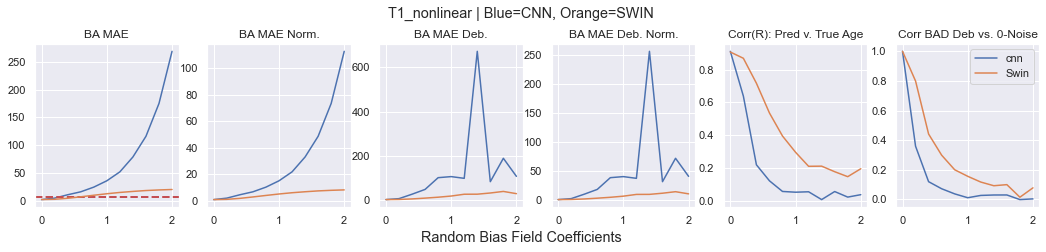

In [39]:
for idx in range(len(df1)):
    mod = str(df1.modality[idx])
    cnn = np.array([np.abs(df1.iloc[idx].dataframe.age_delta_1).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_2).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_3).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_4).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_5).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_6).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_7).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_8).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_9).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_10).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_11).mean(),

                   ])
    swin = np.array([np.abs(df2.iloc[idx].dataframe.age_delta_1).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_2).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_3).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_4).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_5).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_6).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_7).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_8).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_9).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_10).mean(), 
         np.abs(df2.iloc[idx].dataframe.age_delta_11).mean(), 

                    ])
#     pearsonr
    fig, axs = plt.subplots(1,6,figsize=(18,3), facecolor='white')
    axs = axs.flatten()
    
    axs[0].plot(noiseSTD, cnn)
    axs[0].axhline(y=6.253, color='r', linestyle='dashed', label='Mean Age\nFailure Case', linewidth=2)
    axs[0].plot(noiseSTD, swin)
    axs[0].set_title('BA MAE')
    
    axs[1].plot(noiseSTD, cnn/cnn[0])
    axs[1].plot(noiseSTD, swin/swin[0])  
    axs[1].set_title('BA MAE Norm.')
    
    cnn = np.array([np.abs(df1.iloc[idx].dataframe.age_delta_decon_1).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_2).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_3).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_4).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_5).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_6).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_7).mean(), 
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_8).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_9).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_10).mean(),
        np.abs(df1.iloc[idx].dataframe.age_delta_decon_11).mean(),

                   ])
    swin = np.array([np.abs(df2.iloc[idx].dataframe.age_delta_decon_1).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_2).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_3).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_4).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_5).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_6).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_7).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_8).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_9).mean(),
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_10).mean(), 
        np.abs(df2.iloc[idx].dataframe.age_delta_decon_11).mean(), 
                     

                    ])
    
    axs[2].plot(noiseSTD, cnn)
    axs[2].plot(noiseSTD, swin)
    axs[2].set_title('BA MAE Deb.')
    
    axs[3].plot(noiseSTD, cnn/cnn[0])
    axs[3].plot(noiseSTD, swin/swin[0]) 
    axs[3].set_title('BA MAE Deb. Norm.')
    
    cnn = np.array([pearsonr(df1.iloc[idx].dataframe.output_age_1, df1.iloc[idx].dataframe.target_age), 
        pearsonr(df1.iloc[idx].dataframe.output_age_2, df1.iloc[idx].dataframe.target_age),
        pearsonr(df1.iloc[idx].dataframe.output_age_3, df1.iloc[idx].dataframe.target_age),
        pearsonr(df1.iloc[idx].dataframe.output_age_4, df1.iloc[idx].dataframe.target_age),
        pearsonr(df1.iloc[idx].dataframe.output_age_5, df1.iloc[idx].dataframe.target_age),
        pearsonr(df1.iloc[idx].dataframe.output_age_6, df1.iloc[idx].dataframe.target_age),
        pearsonr(df1.iloc[idx].dataframe.output_age_7, df1.iloc[idx].dataframe.target_age),
        pearsonr(df1.iloc[idx].dataframe.output_age_8, df1.iloc[idx].dataframe.target_age),
        pearsonr(df1.iloc[idx].dataframe.output_age_9, df1.iloc[idx].dataframe.target_age),
        pearsonr(df1.iloc[idx].dataframe.output_age_10, df1.iloc[idx].dataframe.target_age),
        pearsonr(df1.iloc[idx].dataframe.output_age_11, df1.iloc[idx].dataframe.target_age),

                   ])
    swin = np.array([pearsonr(df2.iloc[idx].dataframe.output_age_1, df2.iloc[idx].dataframe.target_age), 
        pearsonr(df2.iloc[idx].dataframe.output_age_2, df2.iloc[idx].dataframe.target_age),
        pearsonr(df2.iloc[idx].dataframe.output_age_3, df2.iloc[idx].dataframe.target_age),
        pearsonr(df2.iloc[idx].dataframe.output_age_4, df2.iloc[idx].dataframe.target_age),
        pearsonr(df2.iloc[idx].dataframe.output_age_5, df2.iloc[idx].dataframe.target_age),
        pearsonr(df2.iloc[idx].dataframe.output_age_6, df2.iloc[idx].dataframe.target_age),
        pearsonr(df2.iloc[idx].dataframe.output_age_7, df2.iloc[idx].dataframe.target_age),
        pearsonr(df2.iloc[idx].dataframe.output_age_8, df2.iloc[idx].dataframe.target_age),
        pearsonr(df2.iloc[idx].dataframe.output_age_9, df2.iloc[idx].dataframe.target_age),
        pearsonr(df2.iloc[idx].dataframe.output_age_10, df2.iloc[idx].dataframe.target_age),
        pearsonr(df2.iloc[idx].dataframe.output_age_11, df2.iloc[idx].dataframe.target_age),

                   ])
    
#     pearsonr(dfs[idx].target_age, dfs[idx].mean_output_age)[0]
    
    axs[4].plot(noiseSTD, cnn[:,0])
    axs[4].plot(noiseSTD, swin[:,0]) 
    axs[4].set_title('Corr(R): Pred v. True Age')
    
    baseCNN = df1.iloc[idx].dataframe.age_delta_decon_1
    baseSWIN = df2.iloc[idx].dataframe.age_delta_decon_1
    
    cnn = np.array([pearsonr(df1.iloc[idx].dataframe.age_delta_decon_1, baseCNN), 
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_2, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_3, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_4, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_5, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_6, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_7, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_8, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_9, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_10, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_11, baseCNN),
                    

                   ])
    swin = np.array([pearsonr(df2.iloc[idx].dataframe.age_delta_decon_1, baseSWIN), 
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_2, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_3, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_4, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_5, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_6, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_7, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_8, baseSWIN), 
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_9, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_10, baseSWIN),
         pearsonr(df2.iloc[idx].dataframe.age_delta_decon_11, baseSWIN),

                   ])
    
    
    axs[5].plot(noiseSTD, cnn[:,0], label='cnn')
    axs[5].plot(noiseSTD, swin[:,0], label='Swin')  
    axs[5].set_title('Corr BAD Deb vs. 0-Noise')
    axs[5].legend()
    
    fig.suptitle(mod + ' | Blue=CNN, Orange=SWIN', y=1.05)
    fig.supxlabel('Random Bias Field Coefficients', y=-0.05)

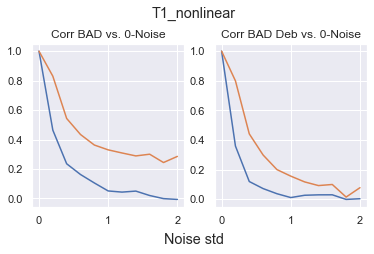

In [40]:


for idx in range(len(df1)):
    
    mod = df1.modality[idx]
    
    fig, axs = plt.subplots(1,2,figsize=(6,3))
    axs = axs.flatten()

    baseCNN = df1.iloc[idx].dataframe.age_delta_1
    baseSWIN = df2.iloc[idx].dataframe.age_delta_1
    
    cnn = np.array([pearsonr(df1.iloc[idx].dataframe.age_delta_1, baseCNN), 
        pearsonr(df1.iloc[idx].dataframe.age_delta_2, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_3, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_4, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_5, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_6, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_7, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_8, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_9, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_10, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_11, baseCNN),
#         pearsonr(df1.iloc[idx].dataframe.age_delta_12, baseCNN),
                   ])
    swin = np.array([pearsonr(df2.iloc[idx].dataframe.age_delta_1, baseSWIN), 
        pearsonr(df2.iloc[idx].dataframe.age_delta_2, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_3, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_4, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_5, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_6, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_7, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_8, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_9, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_10, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_11, baseSWIN),
#         pearsonr(df2.iloc[idx].dataframe.age_delta_12, baseSWIN),
                   ])
    
    axs[0].plot(noiseSTD, cnn[:,0])
    axs[0].plot(noiseSTD, swin[:,0])
    axs[0].set_title('Corr BAD vs. 0-Noise')
    
    
    baseCNN = df1.iloc[idx].dataframe.age_delta_decon_1
    baseSWIN = df2.iloc[idx].dataframe.age_delta_decon_1
    
    cnn = np.array([pearsonr(df1.iloc[idx].dataframe.age_delta_decon_1, baseCNN), 
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_2, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_3, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_4, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_5, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_6, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_7, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_8, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_9, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_10, baseCNN),
        pearsonr(df1.iloc[idx].dataframe.age_delta_decon_11, baseCNN),
#         pearsonr(df1.iloc[idx].dataframe.age_delta_decon_12, baseCNN),
                   ])
    swin = np.array([pearsonr(df2.iloc[idx].dataframe.age_delta_decon_1, baseSWIN), 
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_2, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_3, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_4, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_5, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_6, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_7, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_8, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_9, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_10, baseSWIN),
        pearsonr(df2.iloc[idx].dataframe.age_delta_decon_11, baseSWIN),
#         pearsonr(df2.iloc[idx].dataframe.age_delta_decon_12, baseSWIN),
                   ])
    
    
    axs[1].plot(noiseSTD, cnn[:,0])
    axs[1].plot(noiseSTD, swin[:,0])  
    axs[1].set_title('Corr BAD Deb vs. 0-Noise')
    
    fig.suptitle(mod, y=1.05)
    fig.supxlabel('Noise std', y=-0.06)
    

In [30]:
cnn

array([[ 1.00000000e+00,  0.00000000e+00],
       [ 3.59118060e-01,  2.81836063e-77],
       [ 1.19573118e-01,  1.86455220e-09],
       [ 7.18682959e-02,  3.14007739e-04],
       [ 3.72330924e-02,  6.21685506e-02],
       [ 1.12201813e-02,  5.74206205e-01],
       [ 2.67905161e-02,  1.79669149e-01],
       [ 2.96418842e-02,  1.37638707e-01],
       [ 2.98860406e-02,  1.34425484e-01],
       [-1.33403787e-03,  9.46739409e-01],
       [ 3.37353863e-03,  8.65851513e-01]])